<a href="https://colab.research.google.com/github/lagosmanuel/ML-ANN/blob/main/proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 2 - Inteligencia Artificial 2024 🤖

### Comisión 5 - Manuel Lagos


---



# Importar las librerías necesarias

In [1]:
!pip install scikeras

# Importar las librerías
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scikeras

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from tensorflow import keras
from keras import Sequential, layers, Input
from scikeras.wrappers import KerasClassifier

from pandas.api.types import is_numeric_dtype
from math import floor

# Carga y análisis de datos

In [2]:
# Cargar el dataset
df = pd.read_csv("football_train.csv")
print(f"El conjunto tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

El conjunto tiene 5320 filas y 22 columnas.


In [97]:
df.sample(10)

,Goals,Shots,Shots_on_target,Corners,Fouls_commited,Offsides,Yellow_cards,Red_cards,Corners_received,Fouls_received,...,Shots_on_target_received,Goals_received,Played_Matches,Season,City,Stadium,Stadium_capacity,Ownership,Dominant_team,Position
3749,17.0,286,88,114,321,0,45.0,1.0,140,265,...,122,37,26,2021,London,Craven Cottage,24500,Shahid Khan,2.0,3
1216,2.0,14,6,5,11,0,1.0,0.0,10,10,...,4,0,1,1718,Newcastle upon Tyne,St James' Park,52305,Saudi Public Investment Fund,2.0,2
868,30.0,324,108,142,292,0,44.0,0.0,220,381,...,149,36,33,1718,Burnley,Turf Moor,21944,ALK Capital,2.0,1
4639,14.0,66,30,21,36,0,2.0,0.0,8,45,...,17,3,4,2223,London,Emirates Stadium,60704,Kroenke Sports & Entertainment,0.0,0
3094,17.0,192,60,85,155,0,19.0,0.0,101,178,...,80,23,17,2021,Burnley,Turf Moor,21944,ALK Capital,2.0,2
1886,42.0,350,147,122,283,0,52.0,3.0,134,257,...,126,37,25,1819,Manchester,Old Trafford,74310,Glazer family,2.0,1
1616,23.0,211,70,77,190,0,37.0,1.0,144,187,...,106,33,21,1819,Burnley,Turf Moor,21944,ALK Capital,2.0,2
2640,35.0,326,116,125,202,0,11.0,0.0,63,202,...,60,27,19,1920,London,Stamford Bridge,41837,Todd Boehly,1.0,0
4324,29.0,309,104,131,340,0,47.0,3.0,188,309,...,155,64,31,2122,Watford,Vicarage Road,22200,Gino Pozzo,2.0,3
5053,51.0,417,152,135,411,0,57.0,2.0,236,410,...,178,68,38,2223,Leicester,King Power Stadium,32312,King Power International Group,2.0,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5320 entries, 0 to 5319
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Team                      5320 non-null   object 
 1   Goals                     4856 non-null   float64
 2   Shots                     5320 non-null   int64  
 3   Shots_on_target           5320 non-null   int64  
 4   Corners                   5320 non-null   int64  
 5   Fouls_commited            5320 non-null   int64  
 6   Offsides                  5320 non-null   int64  
 7   Yellow_cards              2157 non-null   float64
 8   Red_cards                 5029 non-null   float64
 9   Corners_received          5320 non-null   int64  
 10  Fouls_received            5320 non-null   int64  
 11  Shots_received            5320 non-null   int64  
 12  Shots_on_target_received  5320 non-null   int64  
 13  Goals_received            5320 non-null   int64  
 14  Played_M

In [ ]:
# Buscar atributos que no sean de tipo numérico
for attr in df.columns:
  if (not is_numeric_dtype(df[attr])):
    print(f"El atributo {attr} no es de tipo numérico, es de tipo {df[attr].dtype}.")

In [ ]:
# Buscar atributos que tengan valores nulos
for attr in df.columns:
  na_count = df[attr].isna().sum()
  if (na_count > 0):
    print(f"Para el atributo {attr} hay {na_count} ejemplos nulos.")

# Procesamiento de los datos

In [3]:
# Mapeo los valores del atributo Dominant_team a un número
dominant_values = df["Dominant_team"].unique()
print(f"Los valores del atributo Dominant_team son: {dominant_values}")

map_dominant = {
    "very_dominant": 0,
    "dominant": 1,
    "not_dominant": 2,
}

df["Dominant_team"] = df["Dominant_team"].map(map_dominant)

Los valores del atributo Dominant_team son: ['not_dominant' 'dominant' '0' 'very_dominant']


In [4]:
# Mapeo los valores del atributo Position a un número
position_values = df["Position"].unique()
print(f"Los valores del atributo Position son: {position_values}")

map_position = {
    "top-4": 0,
    "5-a-7": 1,
    "media-tabla": 2,
    "descenso": 3
}

df["Position"] = df["Position"].map(map_position).astype("Int64")

Los valores del atributo Position son: ['media-tabla' nan '5-a-7' 'descenso' 'top-4']


In [5]:
# Elimino las columnas que considero que no son relevantes
df.drop(columns=["City"], inplace=True, errors="ignore")
df.drop(columns=["Stadium"], inplace=True, errors="ignore")
df.drop(columns=["Stadium_capacity"], inplace=True, errors="ignore")
df.drop(columns=["Ownership"], inplace=True, errors="ignore")

In [6]:
# Función para rellenar los valores faltantes de la columna 'attr' en el dataframe 'df'
def fill_attr(df, attr):
  for index, row in df[df[attr].isna()].iterrows():
    values = []
    team = row["Team"]
    season = row["Season"]

    prev_row = df.iloc[index-1] if index-1 > 0 else None
    next_row = df.iloc[index+1] if index+1 < len(df) else None

    if (prev_row is not None and not pd.isna(prev_row[attr])
        and prev_row["Team"] == team and prev_row["Season"] == season):
      values.append(prev_row[attr])

    if (next_row is not None and not pd.isna(next_row[attr])
        and next_row["Team"] == team and next_row["Season"] == season):
      values.append(next_row[attr])

    if (values != []):
      df.at[index, attr] = floor(sum(values)/len(values))


In [7]:
# Relleno los valores faltantes de las siguientes columnas:
fill_attr(df, "Goals")
fill_attr(df, "Position")
fill_attr(df, "Yellow_cards")
fill_attr(df, "Red_cards")
fill_attr(df, "Dominant_team")

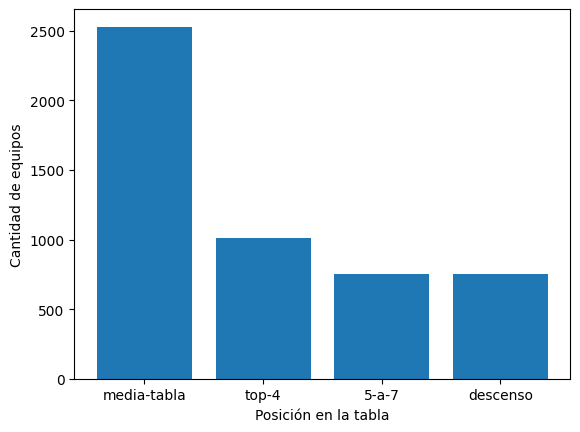

In [ ]:
# Distribución de los ejemplos (filas del dataset) para cada clase
map_position_inv = {v: k for k, v in map_position.items()}
position_counts = df["Position"].map(map_position_inv).value_counts()

# Crear el histograma
plt.bar(position_counts.index, position_counts.values)

# Agregar etiquetas y título
plt.xlabel("Posición en la tabla")
plt.ylabel("Cantidad de equipos")

# Mostrar el histograma
plt.show()

In [8]:
# Elimino la columna Team
df.drop(columns=["Team"], inplace=True, errors="ignore")

In [9]:
# Elimino los ejemplos que hayan quedado con valores nulos
df.dropna(inplace=True)

In [10]:
# Valores de la columna target.
Y = df["Position"].values

# Porción del dataframe con los atributostrain_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1).
X = df.drop(columns = ["Position"])

In [11]:
# Porcentajes para datos de validación y test.
test_size = 0.15
val_size = 0.10

# La función train_test_split separa los datos (X, Y) en dos porciones
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state = 10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size, random_state = 10)

# Nos guardamos los nombres de los atributos para más adelante
feature_names = X_train.columns.values[:-1]

print("Datos de entrenamiento:\n\tCantidad de ejemplos (filas): {}\n\tCantidad de atributos (columnas): {}\n".format(X_train.shape[0], X_train.shape[1]))
print("Datos de validación:\n\tCantidad de ejemplos (filas): {}\n\tCantidad de atributos (columnas): {}\n".format(X_val.shape[0], X_val.shape[1]))
print("Datos de test:\n\tCantidad de ejemplos (filas): {}\n\tCantidad de atributos (columnas): {}".format(X_test.shape[0], X_test.shape[1]))

Datos de entrenamiento:
	Cantidad de ejemplos (filas): 3991
	Cantidad de atributos (columnas): 16

Datos de validación:
	Cantidad de ejemplos (filas): 444
	Cantidad de atributos (columnas): 16

Datos de test:
	Cantidad de ejemplos (filas): 783
	Cantidad de atributos (columnas): 16


In [ ]:
train_df = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(y_train).reset_index(drop=True)], axis=1)
val_df = pd.concat([X_val.reset_index(drop=True), pd.DataFrame(y_val).reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(y_test).reset_index(drop=True)], axis=1)

# Desarrollo de un Árbol de Decisión

In [ ]:
# Creamos un árbol de decisión (AD)
max_depth_range = [4, 8, 16, 32, 64, 128, 256]
min_samples_leaf_range = [1, 2, 3, 4, 5]
criterion_range = ["gini", "entropy"]
class_weights = dict(enumerate(compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)))

tree_params = dict(
  criterion: criterion_range,
  max_depth: max_depth_range,
  min_samples_leaf: min_samples_leaf_range
)

clf = GridSearchCV(DecisionTreeClassifier(class_weight = class_weights), tree_params, cv=5)

# Se ajusta el AD con los datos de entrenamiento
clf = clf.fit(X_train, y_train)

param_grid = pd.concat([pd.DataFrame(clf.cv_results_["params"]), pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])], axis=1)
param_best = clf.best_params_
score_best = clf.best_score_

print(param_grid)
print(f"El mejor score obtenido es: {score_best}")
print(f"La combinación de parámetros es: {param_best}")
print(f"El peso de las clases es: {class_weights}")

Fitting 5 folds for each of 70 candidates, totalling 350 fits
   criterion  max_depth  min_samples_leaf  Accuracy
0       gini          4                 1  0.679782
1       gini          4                 2  0.679531
2       gini          4                 3  0.679531
3       gini          4                 4  0.681035
4       gini          4                 5  0.679783
..       ...        ...               ...       ...
65   entropy        256                 1  0.784014
66   entropy        256                 2  0.778248
67   entropy        256                 3  0.766724
68   entropy        256                 4  0.760463
69   entropy        256                 5  0.750691

[70 rows x 4 columns]
El mejor score obtenido es: 0.7910288863585748
La combinación de parámetros es: {'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 1}
El peso de las clases es: {0: 1.2379032258064515, 1: 1.6882402707275803, 2: 0.49912456228114055, 3: 1.676890756302521}


In [ ]:
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83       143
         1.0       0.71      0.59      0.64       114
         2.0       0.82      0.85      0.83       397
         3.0       0.76      0.71      0.74       129

    accuracy                           0.79       783
   macro avg       0.77      0.75      0.76       783
weighted avg       0.79      0.79      0.79       783



# Desarrollo de una Red Neuronal Artificial

In [12]:
# Onehot encoder
enc = OneHotEncoder()

# El encoder define un mapeo para las etiquetas.
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val_enc = enc.transform(y_val.reshape(-1, 1)).toarray() # Aquí usar transform.
y_test_enc = enc.transform(y_test.reshape(-1, 1)).toarray() # Aquí usar transform.

In [13]:
num_features = X_train.shape[1]
num_outputs = y_train_enc.shape[1]

def define_model(neurons, hidden_layers, activation, learning_rate):
    model = Sequential()

    # Capa de entrada de la red
    model.add(Input(shape=(num_features, )))

    # Capas ocultas
    for i in range(hidden_layers):
      model.add(layers.Dense(neurons, activation = activation))

    # Capa de salida de la red
    model.add(layers.Dense(num_outputs, activation = "softmax"))

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])
    return model

In [18]:
neurons = 100
hidden_layers = 5
activation = "silu"
learning_rate = 1e-3
eps = 300
bs = 16

model = define_model(neurons, hidden_layers, activation, learning_rate)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                     │ (None, 100)                 │           1,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 4)                   │             404 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,504 (166.03 KB)

 Trainable params: 42,504 (166.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
result = model.fit(X_train, y_train_enc, batch_size = bs, epochs = eps, validation_data=(X_val, y_val_enc))

Epoch 1/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4190 - loss: 9.0602 - val_accuracy: 0.5923 - val_loss: 0.9543
Epoch 2/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5526 - loss: 1.3104 - val_accuracy: 0.6554 - val_loss: 0.8858
Epoch 3/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6287 - loss: 0.9514 - val_accuracy: 0.6644 - val_loss: 0.7449
Epoch 4/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6400 - loss: 0.8536 - val_accuracy: 0.6284 - val_loss: 0.8312
Epoch 5/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6511 - loss: 0.8165 - val_accuracy: 0.6622 - val_loss: 0.8111
Epoch 6/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6783 - loss: 0.7558 - val_accuracy: 0.6059 - val_loss: 0.7705
Epoch 7/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6835 - loss: 0.7459 - val_accuracy: 0.5833 - val_loss: 0.9600
Epoch 8/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7000 - loss: 0.6992 - val_accu

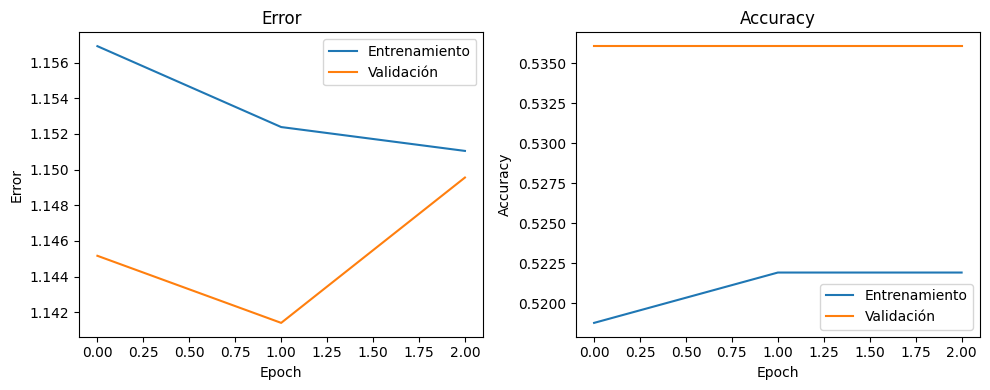

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Error
ax1.plot(result.history['loss'], label='Entrenamiento')
ax1.plot(result.history['val_loss'], label='Validación')
ax1.set_title('Error')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Error')
ax1.legend()

# Accuracy
ax2.plot(result.history['accuracy'], label='Entrenamiento')
ax2.plot(result.history['val_accuracy'], label='Validación')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()